# Evaluation

In [1]:
import json
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

from sklearn import metrics
from rouge import Rouge

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Functions ###
def computeROUGE(reference, predicted):
    rouge = Rouge()
    scores = [rouge.get_scores(new, old) for old, new in zip(reference, predicted)]

    total_scores = {"rouge-1": {"f": 0, "p": 0, "r": 0}, "rouge-2": {"f": 0, "p": 0, "r": 0}, "rouge-l": {"f": 0, "p": 0, "r": 0}}

    for score in scores:
        for key in total_scores.keys():
            total_scores[key]['f'] += score[0][key]['f']
            total_scores[key]['p'] += score[0][key]['p']
            total_scores[key]['r'] += score[0][key]['r']

    for key in total_scores.keys():
        total_scores[key]['f'] /= len(scores)
        total_scores[key]['p'] /= len(scores)
        total_scores[key]['r'] /= len(scores)
    
    return total_scores  

## Summary Length

In [3]:
### Functions ####
##################

def getOriginalSummary(uri):
    with open(uri) as f:
        ticket = json.load(f)

    sum = ""    
    if ticket['Summary'] is not None:
        sum = ticket['Summary']
    
    return sum    

def createEvaluationCSV(directory):
    evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "reruns", "ticket_uri", "output_uri", "violation_actual", "violation_predicted", "summary_original", "length_original", "summary_old", "length_old", "summary_new", "length_new", "correction_in_range"])

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        outputUri = directory + filename

        if not filename.endswith(".json"):
            continue

        with open(outputUri) as f:
            result = json.load(f)

        if (len(result["output"]["summary_new"]) <= 70) & (len(result["output"]["summary_new"]) >= 39):
            in_range = "TRUE"
        else:
            in_range = "FALSE"

        summary_org = getOriginalSummary(result["input_data"]["ticket_uri"])

        new_row = {
            'jira': result["input_data"]["jira"], 
            'ticketId': result["input_data"]["id"], 
            'evolution': result["input_data"]["evolution"], 
            'reruns': result["reruns"],
            'ticket_uri': result["input_data"]["ticket_uri"],
            'output_uri': outputUri, 
            'violation_actual': result["violation_actual"], 
            'violation_predicted': result["output"]["violation_predicted"],
            'summary_original': summary_org,
            'length_original': len(summary_org),
            'summary_old': result["output"]["summary_old"],
            'length_old': len(result["output"]["summary_old"]), 
            'summary_new': result["output"]["summary_new"],
            'length_new': len(result["output"]["summary_new"]), 
            'correction_in_range': in_range
            }

        evalDF.loc[len(evalDF)]=new_row

    # Save data to csv
    evalDF.to_csv(directory + "evaluatedSummarys.csv", index=False)


### 0-Shot

In [ ]:
directory = "./evaluation/summary/gpt-4-0125-preview/0Shot/"

#### Create csv

In [ ]:
createEvaluationCSV(directory)

#### Detection

In [ ]:
evalDF = pd.read_csv(directory + "evaluatedSummarys.csv")

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label=True)
recall = metrics.recall_score(actual, predicted, pos_label=True)
f2 = metrics.fbeta_score(actual, predicted, beta=2, pos_label=True)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[True, False])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Smell", "No Smell"])

cm_display.plot()
plt.show()

## Oben Links = TP (Verstoß wird erkannt und liegt vor)
## Unten Rechts = TN (Verstoß wird nicht erkannt und liegt nicht vor)
## Oben Rechts = FN (Verstoß wird nicht erkannt obwohl einer vorliegt)
## Unten Links = FP (Verstoß wird erkannt obwohl keiner vorliegt)

In [ ]:
print("Accuracy: " + str(round(accuracy, 4)))
print("Precision: " + str(round(precision, 4)))
print("Recall: " + str(round(recall, 4)))
print("F2: " + str(round(f2, 4)))

#### Correction

In [ ]:
allTrue = evalDF_runs["correction_in_range"].value_counts()[True]
allFalse = evalDF_runs["correction_in_range"].value_counts()[False]

# correctedTickets = evalDF_runs[evalDF_runs["violation_actual"] == "TRUE"]
successRate = evalDF_runs["correction_in_range"].value_counts(normalize=True)[True]

print("# True: " + str(allTrue))
print("# False: " + str(allFalse))
print("Success rate: " + str(round(successRate, 2)))

In [ ]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == True:
        reference = np.append(reference, row["summary_original"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores:")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

### Few-Shot

In [ ]:
directory = "./evaluation/summary/gpt-4-0125-preview/FewShot/"

#### Create csv

In [ ]:
createEvaluationCSV(directory)

#### Detection

In [ ]:
evalDF = pd.read_csv(directory + "evaluatedSummarys.csv")

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label=True)
recall = metrics.recall_score(actual, predicted, pos_label=True)
f2 = metrics.fbeta_score(actual, predicted, beta=2, pos_label=True)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[True, False])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Smell", "No Smell"])

cm_display.plot()
plt.show()

In [ ]:
print("Accuracy: " + str(round(accuracy, 4)))
print("Precision: " + str(round(precision, 4)))
print("Recall: " + str(round(recall, 4)))
print("F2: " + str(round(f2, 4)))

#### Correction

In [ ]:
allTrue = evalDF_runs["correction_in_range"].value_counts()[True]
allFalse = evalDF_runs["correction_in_range"].value_counts()[False]

# correctedTickets = evalDF_runs[evalDF_runs["violation_actual"] == "TRUE"]
successRate = evalDF_runs["correction_in_range"].value_counts(normalize=True)[True]

print("# True: " + str(allTrue))
print("# False: " + str(allFalse))
print("Success rate: " + str(round(successRate, 2)))

In [ ]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == True:
        reference = np.append(reference, row["summary_original"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Sum):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

### 0-Shot CoT

In [ ]:
directory = "./evaluation/summary/gpt-4-0125-preview/0ShotCoT/"

#### Create csv

In [ ]:
createEvaluationCSV(directory)

#### Detection

In [ ]:
evalDF = pd.read_csv(directory + "evaluatedSummarys.csv")

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label=True)
recall = metrics.recall_score(actual, predicted, pos_label=True)
f2 = metrics.fbeta_score(actual, predicted, beta=2, pos_label=True)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[True, False])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Smell", "No Smell"])

cm_display.plot()
plt.show()

In [ ]:
print("Accuracy: " + str(round(accuracy, 4)))
print("Precision: " + str(round(precision, 4)))
print("Recall: " + str(round(recall, 4)))
print("F2: " + str(round(f2, 4)))

#### Correction

In [ ]:
allTrue = evalDF_runs["correction_in_range"].value_counts()[True]
allFalse = evalDF_runs["correction_in_range"].value_counts()[False]

# correctedTickets = evalDF_runs[evalDF_runs["violation_actual"] == "TRUE"]
successRate = evalDF_runs["correction_in_range"].value_counts(normalize=True)[True]

print("# True: " + str(allTrue))
print("# False: " + str(allFalse))
print("Success rate: " + str(round(successRate, 2)))

In [ ]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == True:
        reference = np.append(reference, row["summary_old"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Sum):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

### Few-Shot CoT

In [ ]:
directory = "./evaluation/summary/gpt-4-0125-preview/FewShotCoT/"

#### Create csv

In [ ]:
createEvaluationCSV(directory)

#### Detection

In [ ]:
evalDF = pd.read_csv(directory + "evaluatedSummarys.csv")

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label=True)
recall = metrics.recall_score(actual, predicted, pos_label=True)
f2 = metrics.fbeta_score(actual, predicted, beta=2, pos_label=True)

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=[True, False])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Smell", "No Smell"])

cm_display.plot()
plt.show()

In [ ]:
print("Accuracy: " + str(round(accuracy, 4)))
print("Precision: " + str(round(precision, 4)))
print("Recall: " + str(round(recall, 4)))
print("F2: " + str(round(f2, 4)))

#### Correction

In [ ]:
allTrue = evalDF_runs["correction_in_range"].value_counts()[True]
allFalse = evalDF_runs["correction_in_range"].value_counts()[False]

# correctedTickets = evalDF_runs[evalDF_runs["violation_actual"] == "TRUE"]
successRate = evalDF_runs["correction_in_range"].value_counts(normalize=True)[True]

print("# True: " + str(allTrue))
print("# False: " + str(allFalse))
print("Success rate: " + str(round(successRate, 2)))

In [ ]:
reference = np.array([])
new_summary = np.array([])

for index, row in evalDF.iterrows():

    if row["violation_actual"] == True:
        reference = np.append(reference, row["summary_old"])
        new_summary = np.append(new_summary, row["summary_new"])

print("Average ROUGE scores (Sum):")
total_scores = computeROUGE(reference, new_summary)
print(total_scores)

### Total

#### Create CSVs

In [ ]:
ZeroShot_df = pd.read_csv("./evaluation/summary/gpt-4-0125-preview/0Shot/evaluatedSummarys.csv")
FewShot_df = pd.read_csv("./evaluation/summary/gpt-4-0125-preview/FewShot/evaluatedSummarys.csv")
ZeroShotCoT_df = pd.read_csv("./evaluation/summary/gpt-4-0125-preview/0ShotCoT/evaluatedSummarys.csv")
FewShotCoT_df = pd.read_csv("./evaluation/summary/gpt-4-0125-preview/FewShotCoT/evaluatedSummarys.csv")

In [ ]:
ZeroShot_df["prompt"] = "0Shot"
FewShot_df["prompt"] = "FewShot"
ZeroShotCoT_df["prompt"] = "0ShotCoT"
FewShotCoT_df["prompt"] = "FewShotCoT"

In [ ]:
frames = [ZeroShot_df, FewShot_df, ZeroShotCoT_df, FewShotCoT_df]
result = pd.concat(frames)

In [ ]:
result.to_csv("./evaluation/summary/gpt-4-0125-preview/totalSummarys.csv", index=False)

In [ ]:
total_smells_df = result[result["violation_actual"] == True]
total_smells_0Run_df = total_smells_df[total_smells_df["reruns"] == 0]
total_smells_1Run_df = total_smells_df[total_smells_df["reruns"] == 1]

In [ ]:
total_smells_0Run_df.to_csv("./evaluation/summary/gpt-4-0125-preview/totalSmells_0Run.csv", index=False)
total_smells_1Run_df.to_csv("./evaluation/summary/gpt-4-0125-preview/totalSmells_1Run.csv", index=False)

#### Create EvalCSV 

In [ ]:
directory = "./evaluation/summary/gpt-4-0125-preview/Consensus/"

In [ ]:
evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "run", "ticket_uri", "output_uri", "summary_original", "preferred_summary", "prompt_type", "model_explanation"])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    outputUri = directory + filename

    if not filename.endswith(".json"):
        continue

    with open(outputUri) as f:
        result = json.load(f)

    summary_org = getOriginalSummary(result["input_data"]["ticket_uri"])

    new_row = {
        'jira': result["input_data"]["jira"], 
        'ticketId': result["input_data"]["id"], 
        'evolution': result["input_data"]["evolution"], 
        'run': result["reruns"],
        'ticket_uri': result["input_data"]["ticket_uri"],
        'output_uri': outputUri, 
        'summary_original': summary_org,
        'preferred_summary': result["output"]["summary"],
        'prompt_type': result["output"]["prompt_type"],
        'model_explanation': result["output"]["explanation"]
        }

    evalDF.loc[len(evalDF)]=new_row

# Save data to csv
evalDF.to_csv(directory + "evaluatedSelection.csv", index=False)

#### Evaluation

In [ ]:
selectionDF = pd.read_csv(directory + "evaluatedSelection.csv")

In [ ]:
counts = selectionDF["prompt_type"].value_counts()
print(counts)

# Update

In [ ]:
directory = "./evaluation/update/gpt-4-0125-preview/"

In [ ]:
evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "reruns", "ticket_uri", "output_uri", "violation_actual", "violation_predicted", "change_actual", "change_predicted", "success"])

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    outputUri = directory + filename

    if not filename.endswith(".json"):
        continue

    with open(outputUri) as f:
        result = json.load(f)

    new_row = {
        'jira': result["input_data"]["jira"], 
        'ticketId': result["input_data"]["id"], 
        'evolution': result["input_data"]["evolution"],
        'reruns': result["reruns"],
        'ticket_uri': result["input_data"]["ticket_uri"],
        'output_uri': outputUri, 
        'violation_actual': result["violation_actual"], 
        'violation_predicted': result["output"]["violation_predicted"],
        'change_actual': result["reason"],
        'change_predicted': result["output"]["fields"],
        'success': None
        }

    evalDF.loc[len(evalDF)]=new_row    

# Save data to csv
evalDF.to_csv(directory + "updateSummarys.csv", index=False)

#### Detection

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["violation_actual"])
    predicted = np.append(predicted, row["violation_predicted"])

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision = metrics.precision_score(actual, predicted, pos_label="TRUE")
recall = metrics.recall_score(actual, predicted, pos_label="TRUE")
f05 = metrics.fbeta_score(actual, predicted, beta=0.5, pos_label="TRUE")

confusion_matrix = metrics.confusion_matrix(actual, predicted, labels=["TRUE", "FALSE"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["TRUE", "FALSE"])

cm_display.plot()
plt.show()

In [ ]:
print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F05: " + str(f05))

#### Correction

In [ ]:
evalDF = pd.read_csv(directory + "updateSummarys_labeled.csv")

In [ ]:
successRate = evalDF["success"].value_counts(normalize=True)[True]
print("Success rate: " + str(successRate))

# Bug Report Strucutre

In [3]:
### Functions ####
##################

def getOriginalDescription(uri):
    
    with open(uri) as f:
        ticket = json.load(f)

    desc = ""    
    if ticket['Description'] is not None:
        desc = ticket['Description']
    
    return desc    

def createEvaluationCSV(directory):
    evalDF = pd.DataFrame(columns=["jira", "ticketId", "evolution", "reruns", "ticket_uri", "output_uri", "desc_original", "desc_revised", "reason", "smell_degree_actual", "smell_degree_predicted", "equal_degree"])

    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        outputUri = directory + filename

        if not filename.endswith(".json"):
            continue

        with open(outputUri) as f:
            result = json.load(f)

        if result["output"]["smell_degree"] == result["smell_actual"]:
            equal = "TRUE"
        else:
            equal = "FALSE"

        desc_org = getOriginalDescription(result["input_data"]["ticket_uri"])

        new_row = {
            'jira': result["input_data"]["jira"], 
            'ticketId': result["input_data"]["id"], 
            'evolution': result["input_data"]["evolution"], 
            'reruns': result["reruns"],
            'ticket_uri': result["input_data"]["ticket_uri"],
            'output_uri': outputUri,
            'desc_original': desc_org,
            'desc_revised': result["output"]["description_new"],
            'reason': result["output"]["reason"],
            'smell_degree_actual': result["smell_actual"], 
            'smell_degree_predicted': result["output"]["smell_degree"],
            'equal_degree': equal
            }

        evalDF.loc[len(evalDF)]=new_row

    # Save data to csv
    evalDF.to_csv(directory + "evaluatedBugReportStructure.csv", index=False)

def getBinaryConfusionMetrics(cm, class_index):
    TP = cm[class_index, class_index]
    FP = cm[:, class_index].sum() - TP
    FN = cm[class_index, :].sum() - TP
    TN = cm.sum() - (FP + FN + TP)

    binary_cm = np.array([[TP, FN], [FP, TN]])

    accuracy = (TP + TN) / cm.sum()
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    recall = TP / (TP + FN) if TP + FN != 0 else 0
    f2_score = (5 * precision * recall) / (4 * precision + recall) if precision + recall != 0 else 0

    metrics = f"Accuracy: {round(accuracy, 4)}, Precision: {round(precision, 4)}, Recall: {round(recall, 4)}, F2-Score: {round(f2_score, 4)}"
    
    return binary_cm, metrics

def plotConfusionMatrix(cm, label):
    plt.figure(figsize=(5,4))
    plt.title(f'2x2 Confusion Matrix for Class {label}')
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Positive", "Negative"], yticklabels=["Positive", "Negative"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


### 0-Shot

In [ ]:
directory = "./evaluation/bugreportStructure/gpt-4-0125-preview/0Shot/"

#### Create csv

In [ ]:
createEvaluationCSV(directory)

#### Detection

In [ ]:
evalDF = pd.read_csv(directory + "evaluatedBugReportStructure.csv")

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 0]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["smell_degree_actual"])
    predicted = np.append(predicted, row["smell_degree_predicted"])

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision_macro = metrics.precision_score(actual, predicted, average='macro')
precision_micro = metrics.precision_score(actual, predicted, average='micro')
precision_weighted = metrics.precision_score(actual, predicted, average='weighted')
recall_macro = metrics.recall_score(actual, predicted, average='macro')
recall_micro = metrics.recall_score(actual, predicted, average='micro')
recall_weighted = metrics.recall_score(actual, predicted, average='weighted')
f2_macro = metrics.fbeta_score(actual, predicted, beta=2, average='macro')
f2_micro = metrics.fbeta_score(actual, predicted, beta=2, average='micro')
f2_weighted = metrics.fbeta_score(actual, predicted, beta=2, average='weighted')

print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision (Macro-average): {round(precision_macro, 4)}")
print(f"Precision (Micro-average): {round(precision_micro, 4)}")
print(f"Precision (Weighted-average): {round(precision_weighted, 4)}")
print(f"Recall (Macro-average): {round(recall_macro, 4)}")
print(f"Recall (Micro-average): {round(recall_micro, 4)}")
print(f"Recall (Weighted-average): {round(recall_weighted, 4)}")
print(f"F2 Score (Macro-average): {round(f2_macro, 4)}")
print(f"F2 Score (Micro-average): {round(f2_micro, 4)}")
print(f"F2 Score (Weighted-average): {round(f2_weighted, 4)}")


In [ ]:
for i, class_name in enumerate(['1', '2', '3']):
    binary_cm, metrics = getBinaryConfusionMetrics(confusion_matrix, i)
    plotConfusionMatrix(binary_cm, class_name)
    print(metrics)

#### Correction

In [ ]:
actualCounts = evalDF_runs["smell_degree_actual"].value_counts()
predictedCounts = evalDF_runs["smell_degree_predicted"].value_counts()
successRate = evalDF_runs["equal_degree"].value_counts(normalize=True)[True]
true_entries = evalDF_runs["equal_degree"].value_counts()[True]
false_entries = evalDF_runs["equal_degree"].value_counts()[False]

print(actualCounts)
print(predictedCounts)
print("# of True: " + str(true_entries))
print("# of False: " + str(false_entries))
print("Success rate: " + str(round(successRate, 2)))

### 0-Shot CoT

In [ ]:
directory = "./evaluation/bugreportStructure/gpt-4-0125-preview/0ShotCoT/"

#### Create csv

In [ ]:
createEvaluationCSV(directory)

#### Detection

In [ ]:
evalDF = pd.read_csv(directory + "evaluatedBugReportStructure.csv")

In [ ]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["smell_degree_actual"])
    predicted = np.append(predicted, row["smell_degree_predicted"])

In [ ]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(actual, predicted)
precision_macro = metrics.precision_score(actual, predicted, average='macro')
precision_micro = metrics.precision_score(actual, predicted, average='micro')
precision_weighted = metrics.precision_score(actual, predicted, average='weighted')
recall_macro = metrics.recall_score(actual, predicted, average='macro')
recall_micro = metrics.recall_score(actual, predicted, average='micro')
recall_weighted = metrics.recall_score(actual, predicted, average='weighted')
f2_macro = metrics.fbeta_score(actual, predicted, beta=2, average='macro')
f2_micro = metrics.fbeta_score(actual, predicted, beta=2, average='micro')
f2_weighted = metrics.fbeta_score(actual, predicted, beta=2, average='weighted')

print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision (Macro-average): {round(precision_macro, 4)}")
print(f"Precision (Micro-average): {round(precision_micro, 4)}")
print(f"Precision (Weighted-average): {round(precision_weighted, 4)}")
print(f"Recall (Macro-average): {round(recall_macro, 4)}")
print(f"Recall (Micro-average): {round(recall_micro, 4)}")
print(f"Recall (Weighted-average): {round(recall_weighted, 4)}")
print(f"F2 Score (Macro-average): {round(f2_macro, 4)}")
print(f"F2 Score (Micro-average): {round(f2_micro, 4)}")
print(f"F2 Score (Weighted-average): {round(f2_weighted, 4)}")

In [ ]:
for i, class_name in enumerate(['1', '2', '3']):
    binary_cm, metrics = getBinaryConfusionMetrics(confusion_matrix, i)
    plotConfusionMatrix(binary_cm, class_name)
    print(metrics)

#### Correction

In [ ]:
actualCounts = evalDF_runs["smell_degree_actual"].value_counts()
predictedCounts = evalDF_runs["smell_degree_predicted"].value_counts()
successRate = evalDF_runs["equal_degree"].value_counts(normalize=True)[True]
true_entries = evalDF_runs["equal_degree"].value_counts()[True]
false_entries = evalDF_runs["equal_degree"].value_counts()[False]

print(actualCounts)
print(predictedCounts)
print("# of True: " + str(true_entries))
print("# of False: " + str(false_entries))
print("Success rate: " + str(round(successRate, 2)))

### Few-Shot

In [4]:
directory = "./evaluation/bugreportStructure/gpt-4-0125-preview/FewShot/"

#### Create csv

In [5]:
createEvaluationCSV(directory)

#### Detection

In [6]:
evalDF = pd.read_csv(directory + "evaluatedBugReportStructure.csv")

In [7]:
actual = np.array([])
predicted = np.array([])

evalDF_runs = evalDF[evalDF["reruns"] <= 1]

for index, row in evalDF_runs.iterrows():

    actual = np.append(actual, row["smell_degree_actual"])
    predicted = np.append(predicted, row["smell_degree_predicted"])

In [8]:
confusion_matrix = metrics.confusion_matrix(actual, predicted)

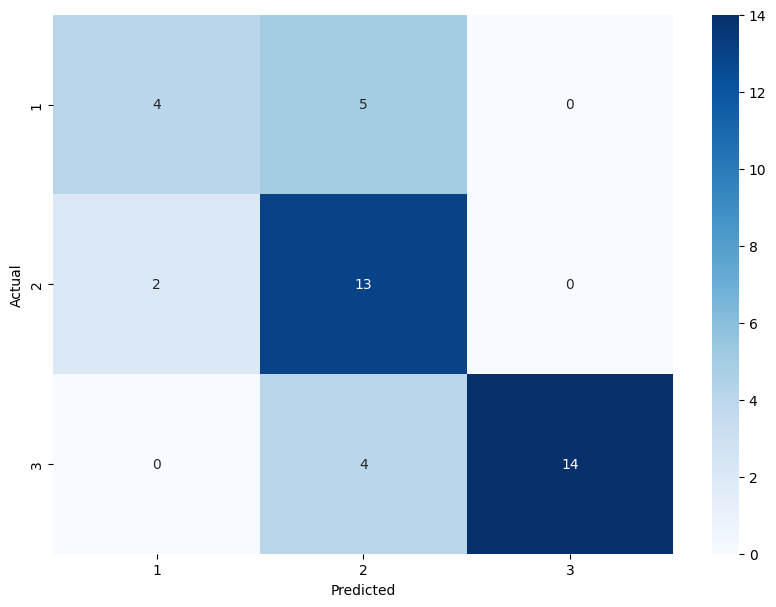

In [9]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1,2,3], yticklabels=[1,2,3])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [10]:
accuracy = metrics.accuracy_score(actual, predicted)
precision_macro = metrics.precision_score(actual, predicted, average='macro')
precision_micro = metrics.precision_score(actual, predicted, average='micro')
precision_weighted = metrics.precision_score(actual, predicted, average='weighted')
recall_macro = metrics.recall_score(actual, predicted, average='macro')
recall_micro = metrics.recall_score(actual, predicted, average='micro')
recall_weighted = metrics.recall_score(actual, predicted, average='weighted')
f2_macro = metrics.fbeta_score(actual, predicted, beta=2, average='macro')
f2_micro = metrics.fbeta_score(actual, predicted, beta=2, average='micro')
f2_weighted = metrics.fbeta_score(actual, predicted, beta=2, average='weighted')

print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision (Macro-average): {round(precision_macro, 4)}")
print(f"Precision (Micro-average): {round(precision_micro, 4)}")
print(f"Precision (Weighted-average): {round(precision_weighted, 4)}")
print(f"Recall (Macro-average): {round(recall_macro, 4)}")
print(f"Recall (Micro-average): {round(recall_micro, 4)}")
print(f"Recall (Weighted-average): {round(recall_weighted, 4)}")
print(f"F2 Score (Macro-average): {round(f2_macro, 4)}")
print(f"F2 Score (Micro-average): {round(f2_micro, 4)}")
print(f"F2 Score (Weighted-average): {round(f2_weighted, 4)}")

Accuracy: 0.7381
Precision (Macro-average): 0.7525
Precision (Micro-average): 0.7381
Precision (Weighted-average): 0.7825
Recall (Macro-average): 0.6963
Recall (Micro-average): 0.7381
Recall (Weighted-average): 0.7381
F2 Score (Macro-average): 0.6943
F2 Score (Micro-average): 0.7381
F2 Score (Weighted-average): 0.734


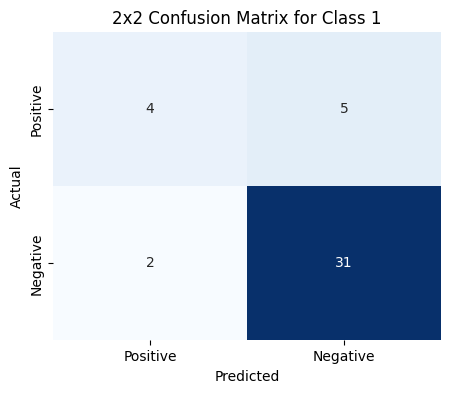

Accuracy: 0.8333, Precision: 0.6667, Recall: 0.4444, F2-Score: 0.4762


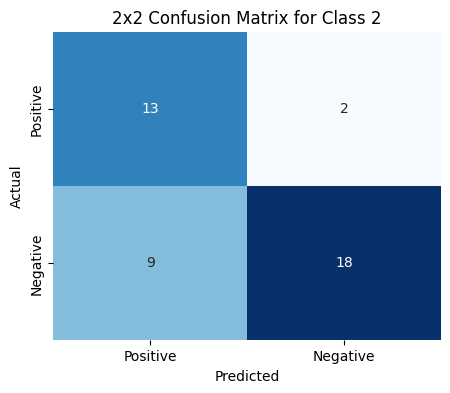

Accuracy: 0.7381, Precision: 0.5909, Recall: 0.8667, F2-Score: 0.7927


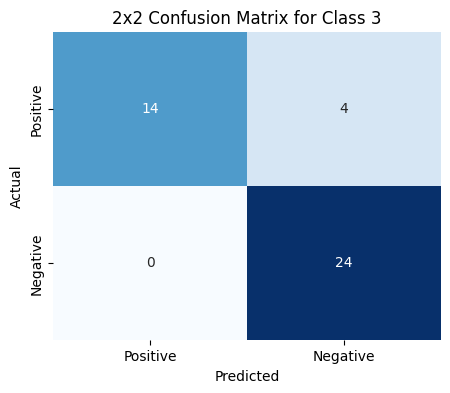

Accuracy: 0.9048, Precision: 1.0, Recall: 0.7778, F2-Score: 0.814


In [11]:
for i, class_name in enumerate(['1', '2', '3']):
    binary_cm, metrics = getBinaryConfusionMetrics(confusion_matrix, i)
    plotConfusionMatrix(binary_cm, class_name)
    print(metrics)

#### Correction

In [12]:
actualCounts = evalDF_runs["smell_degree_actual"].value_counts()
predictedCounts = evalDF_runs["smell_degree_predicted"].value_counts()
successRate = evalDF_runs["equal_degree"].value_counts(normalize=True)[True]
true_entries = evalDF_runs["equal_degree"].value_counts()[True]
false_entries = evalDF_runs["equal_degree"].value_counts()[False]

print(actualCounts)
print(predictedCounts)
print("# of True: " + str(true_entries))
print("# of False: " + str(false_entries))
print("Success rate: " + str(round(successRate, 2)))

smell_degree_actual
3    18
2    15
1     9
Name: count, dtype: int64
smell_degree_predicted
2    22
3    14
1     6
Name: count, dtype: int64
# of True: 31
# of False: 11
Success rate: 0.74


### Few-Shot CoT